In [1]:
# Download MNIST handwritten data from website: http://yann.lecun.com/exdb/mnist/
# The data set including 60000 training data / 10000 testing data
import sys
import gzip, struct
import numpy as np

def read_data(image,label):
    with gzip.open(label) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return image,label

def get_data():
    train_img,train_label = read_data('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
    test_img,test_label = read_data('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')
    return [train_img,train_label,test_img,test_label]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


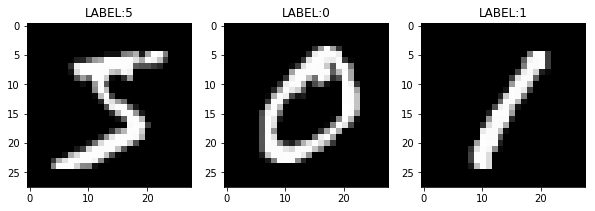

In [2]:
# Examples from data set
import matplotlib.pyplot as plt
%matplotlib inline

X, y, Xt, yt = get_data()
def imshow(img, label):
    plt.imshow(img.reshape((28,28)),cmap='gray')
    plt.title('LABEL:' + label.astype(str))

plt.figure(figsize=(10,20))
plt.subplot(131)
imshow(X[0], y[0])
plt.subplot(132)
imshow(X[1], y[1])
plt.subplot(133)
imshow(X[3], y[3])

In [3]:
# Using dataloader from pytorch to do training and testing
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

# Normalization function
def custom_normalization(data, std, mean):
    return (data - mean) / std
    
batch_size = 200
kwargs = {}

# Get data and normalization
X, y, Xt, yt = get_data()
mean, std = X.mean(), X.std()
X = custom_normalization(X, mean, std)
Xt = custom_normalization(Xt, mean, std)

# Build Tensor Dataset and Loader
train_x, train_y = torch.from_numpy(X.reshape(-1, 1, 28, 28)).float(), torch.from_numpy(y.astype(int))
test_x, test_y = torch.from_numpy(Xt.reshape(-1, 1, 28, 28)).float(), torch.from_numpy(yt.astype(int))

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, **kwargs)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=batch_size, **kwargs)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


In [4]:
# Build LeNet-5 Convolutional Neural Network
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5,padding=2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Transfer data from 3D to 1D 
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
model = LeNet5()

# Using Cross Entropy Loss as loss function
criterion = nn.CrossEntropyLoss(size_average=False)
# Using ADAM as optimizer method
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Weight initialization
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

model.apply(weight_init)

# Training part 
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() # Gradient initialization
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Testing part
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1,20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 463.376343
Train Epoch: 1 [20000/60000 (33%)]	Loss: 62.161247
Train Epoch: 1 [40000/60000 (67%)]	Loss: 22.319952

Test set: Average loss: 0.0751, Accuracy: 9786/10000 (97.0000%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 10.970175
Train Epoch: 2 [20000/60000 (33%)]	Loss: 10.234801
Train Epoch: 2 [40000/60000 (67%)]	Loss: 16.127041

Test set: Average loss: 0.0634, Accuracy: 9804/10000 (98.0000%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 11.181713
Train Epoch: 3 [20000/60000 (33%)]	Loss: 6.111042
Train Epoch: 3 [40000/60000 (67%)]	Loss: 18.435699

Test set: Average loss: 0.0426, Accuracy: 9857/10000 (98.0000%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 12.591546
Train Epoch: 4 [20000/60000 (33%)]	Loss: 9.279142
Train Epoch: 4 [40000/60000 (67%)]	Loss: 19.633623

Test set: Average loss: 0.0418, Accuracy: 9863/10000 (98.0000%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 16.172068
Train Epoch: 5 [20000/60000 (33%)]	Loss: 4.249102
Train Epoch: 5 [40000/60000 (67%)]	Loss: 2.886302

In [223]:
# Save Parameters
trained_dict = model.state_dict()
trained_dict.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [197]:
w1 = trained_dict['conv1.weight']
w1 = w1.numpy().reshape(6,5,5)

In [232]:
file = open('w1.txt','w')
for i in range(6):
    for j in range(5):
        for k in range(5):
            file.writelines(w1[i][j][k].astype(str))
            file.write(' ')
        file.write('\n')
    file.write('\n\n')

In [213]:
w2 = trained_dict['conv2.weight']
w2 = w2.numpy()
w2.shape

(16, 6, 5, 5)

In [231]:
file = open('w2.txt','w')
for i in range(16):
    for j in range(6):
        for k in range(5):
            for z in range(5):
                file.writelines(w2[i][j][k][z].astype(str))
                file.write(' ')
            file.write('\n')
        file.write('\n')
    file.write('\n\n\n')

In [221]:
w3 = trained_dict['conv3.weight']
w3 = w3.numpy()
w3.shape

(120, 16, 5, 5)

In [230]:
file = open('w3.txt','w')
for i in range(120):
    for j in range(16):
        for k in range(5):
            for z in range(5):
                file.writelines(w3[i][j][k][z].astype(str))
                file.write(' ')
            file.write('\n')
        file.write('\n')
    file.write('\n\n\n')

In [225]:
w4 = trained_dict['fc1.weight']
w4 = w4.numpy()
w4.shape

(84, 120)

In [229]:
file = open('w4.txt','w')
for i in range(84):
    for j in range(120):
        file.writelines(w4[i][j].astype(str))
        file.write(' ')
    file.write('\n\n\n')

In [234]:
w5 = trained_dict['fc2.weight']
w5 = w5.numpy()
w5.shape

(10, 84)

In [237]:
file = open('w5.txt','w')
for i in range(10):
    for j in range(84):
        file.writelines(w5[i][j].astype(str))
        file.write(' ')
    file.write('\n\n')

In [242]:
b1 = trained_dict['conv1.bias']
b1 = b1.numpy()
b1.shape

(6,)

In [241]:
b2 = trained_dict['conv2.bias']
b2 = b2.numpy()
b2.shape

(16,)

In [243]:
b3 = trained_dict['conv3.bias']
b3 = b3.numpy()
b3.shape

(120,)

In [244]:
b4 = trained_dict['fc1.bias']
b4 = b4.numpy()
b4.shape

(84,)

In [245]:
b5 = trained_dict['fc2.bias']
b5 = b5.numpy()
b5.shape

(10,)

In [250]:
file = open('bias.txt','w')
for i in range(6):
    file.writelines(b1[i].astype(str))
    file.write(' ')
file.write('\n\n')
for i in range(16):
    file.writelines(b2[i].astype(str))          
    file.write(' ')
file.write('\n\n')
for i in range(120):
    file.writelines(b3[i].astype(str))
    file.write(' ')
file.write('\n\n')
for i in range(84):
    file.writelines(b4[i].astype(str))     
    file.write(' ')
file.write('\n\n')
for i in range(10):
    file.writelines(b5[i].astype(str))      
    file.write(' ')

In [256]:
xxxxxx1, xxxxxx2, xxxxxx3, xxxxxx4 = get_data()
xxxxxx3[0].shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


(28, 28)

In [262]:
file = open('image.txt','w')
for i in range(28):
    for j in range(28):
        file.writelines(xxxxxx3[0][i][j].astype(str))
        file.write(' ')
    file.write('\n')

In [266]:
torch.save(model.state_dict(),'model')